Performance test

In [ ]:
import torch
from tqdm.auto import tqdm

device = "cuda"
n = 10000
W = 0.5 * torch.randn(n, n, device=device) / n**0.5
x = torch.randn(n, device=device)
phi = torch.tanh
dt = 1e-3
for i in (pbar := tqdm(range(10000))):
    x += (-x + phi(W @ x)) * dt
    if i % 1000 == 0:
        pbar.set_description(f"{x.mean():.2f}, {x.std():.2f}")

Empirical DNNs

In [ ]:
# del W
torch.cuda.empty_cache()

Bottleneck is generating Levy samples from scipy. Use [torchlevy](https://github.com/KU-LIM-Lab/torchlevy) instead, which translates the same algorithm to torch primitives.

The speedup is massive (60x) but it has occasional issues with generating nans. The speedup holds even against a pure numpy implementation (45x). Using torchlevy on cpu is faster than a pure numpy implementation by about 3x.

In [ ]:
# !pip install git+https://github.com/UNIST-LIM-Lab/torchlevy.git

In [ ]:
import RMT

from tqdm.auto import tqdm
import numpy as np
import torch

from functools import partial
import multiprocessing as mp

mp.set_start_method("spawn", force=True)

alphas = np.linspace(1, 2, 20)
sigmas_W = np.linspace(0.1, 2, 20)


with mp.Pool(7, partial(torch.set_default_device, "cuda")) as pool:
    results = list(
        tqdm(
            pool.imap(
                partial(
                    RMT.worker,
                    alphas=alphas,
                    sigma_b=0,
                    phi=torch.tanh,
                    width=1000,
                    depth=50,
                ),
                sigmas_W,
            ),
            total=len(sigmas_W),
        )
    )
import matplotlib.pyplot as plt

plt.imshow(results, aspect="auto", extent=(1, 2, 0.1, 2), origin="lower")
plt.colorbar(label="Mean log singular value")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\sigma_W$")
plt.title("Mean log singular value of Jacobian of one layer")
plt.show()

In [ ]:
# optimal num of func calls per subjob
# = total num of func calls / max num of concurrent subjobs on the queue
len(['' for alpha100 in range(100, 201, 5)
        for g100 in range(1, 301, 5)
        for seed in range(50)]) / 300

210.0

In [ ]:
# walltime in minutes for each subjob
# = num of func calls per subjob * seconds per func call / 60 seconds per minute
210 * 5 / 60

17.5

In [54]:
import numpy as np
data = np.load("/import/silo3/wardak/width1000_depth50.npz")
data

NpzFile '/import/silo3/wardak/width1000_depth50.npz' with keys: alpha150_g151_seed16, alpha185_g121_seed44, alpha105_g246_seed29, alpha115_g181_seed26, alpha180_g291_seed35...

In [55]:
from tqdm.auto import tqdm
import re


def to_tup(
    s, pattern=re.compile(r"alpha(?P<alpha>[\d.]+)_g(?P<g>[\d.]+)_seed(?P<seed>\d+)")
):
    return tuple(int(x) for x in pattern.match(s).groups())


means = {to_tup(k): v[~np.isneginf(v)].mean() for k, v in tqdm(data.items())}

  0%|          | 0/63000 [00:00<?, ?it/s]

In [60]:
stds = {to_tup(k): v[~np.isneginf(v)].std() for k, v in tqdm(data.items())}

  0%|          | 0/63000 [00:00<?, ?it/s]

1260


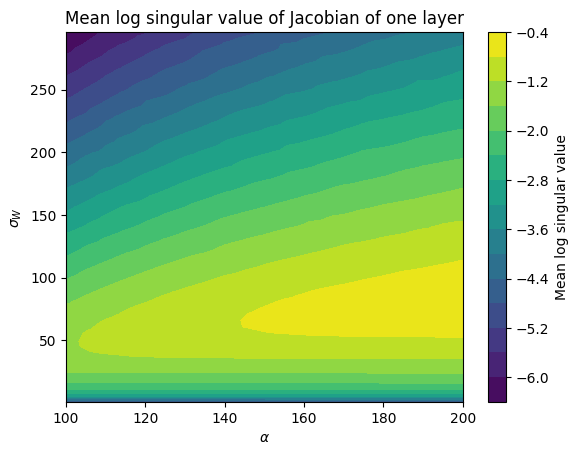

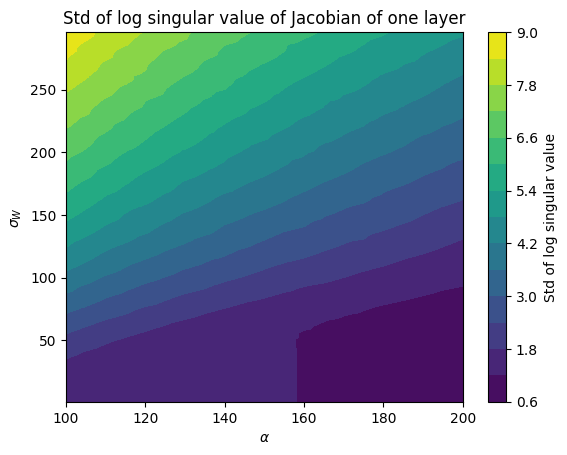

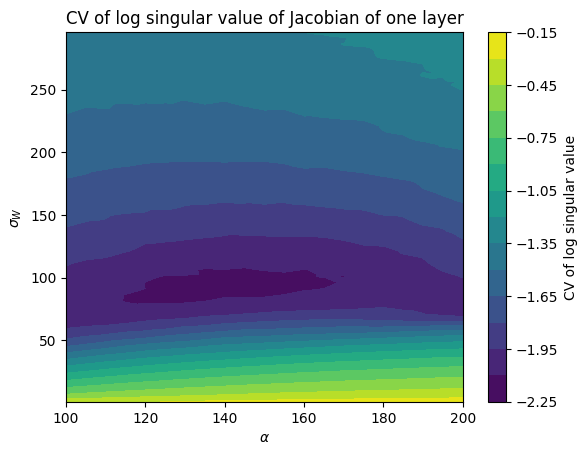

In [62]:
import matplotlib.pyplot as plt

from itertools import groupby


def groupby_mean(data_dict, sort_key=lambda x: x[0][:-1]):
    return {
        k: np.mean([gv for gk, gv in list(grouper)])
        for k, grouper in groupby(sorted(data_dict.items(), key=sort_key), sort_key)
    }


xyz_means = np.array([(k[0], k[1], v) for k, v in groupby_mean(means).items()])

# mask = xyz[:, 0] > 190
mask = np.ones_like(xyz_means[:, 0], dtype=bool)
print(mask.sum())
plt.tricontourf(xyz_means[mask, 0], xyz_means[mask, 1], xyz_means[mask, 2], levels=14)
plt.colorbar(label="Mean log singular value")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\sigma_W$")
plt.title("Mean log singular value of Jacobian of one layer")
plt.show()

xyz_stds = np.array([(k[0], k[1], v) for k, v in groupby_mean(stds).items()])
plt.tricontourf(xyz_stds[mask, 0], xyz_stds[mask, 1], xyz_stds[mask, 2], levels=14)
plt.colorbar(label="Std of log singular value")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\sigma_W$")
plt.title("Std of log singular value of Jacobian of one layer")
plt.show()

xyz_CVs = xyz_means.copy()
xyz_CVs[:, 2] = xyz_stds[:, 2] / xyz_means[:, 2]
plt.tricontourf(xyz_CVs[mask, 0], xyz_CVs[mask, 1], xyz_CVs[mask, 2], levels=14)
plt.colorbar(label="CV of log singular value")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\sigma_W$")
plt.title("CV of log singular value of Jacobian of one layer")
plt.show()
